In [159]:
# Split the data beween train and test data

# Shape and type requirement of different things in python
# Kernel needs to return a matrix
# mean ?

### The Forrester Et AL. (2012) Function 
$$
f(x) = (6x - 2)^2 \sin(12x - 4)
$$

We take it for $x \in [0, 1]$

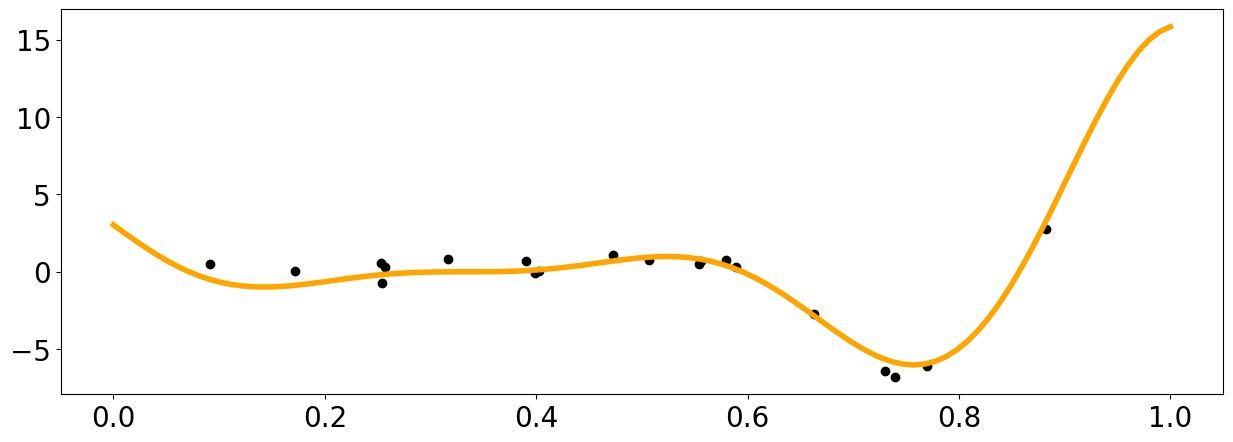

In [160]:
# imports
import numpy as np
import matplotlib.pyplot as plt
from fvgp import GP

############################
## Fetch Data to train on ##
############################

x_data = np.random.rand(20).reshape(-1,1)     # Does this give us a normally distributed noise ?
x_data_test = np.random.rand(10).reshape(-1,1)
x_pred1D = np.linspace(0,1,100).reshape(-1,1)

def forreal(x):
    return ((6 * x - 2) ** 2 ) * np.sin(12 * x - 4 )

y_data = forreal(x_data[:,0]) + (np.random.rand(len(x_data)) - 0.5) * 2
y_data_test = forreal(x_data_test[:,0]) + (np.random.rand(len(x_data_test)) - 0.5) * 2

# Plotting the data
plt.figure(figsize=(15, 5))
plt.plot(x_pred1D,forreal(x_pred1D), color='orange', linewidth=4)
plt.scatter(x_data, y_data, color='black')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

In [161]:
#####################
## Customize my GP ##
#####################

from fvgp.gp_kernels import * 

hps = np.array([
    0.1,  # length scale
    0.1,  # signal or output variance
    1,  # noise variance
    10   # mean function
])

def my_noise(x,hps=hps):
    return np.diag(np.ones((len(x))) * hps[2]) # noise variance
    

def rbf_kernel(x1,x2,hps=hps):
    sigma2 = hps[1]  # signal or output variance
    l = hps[0]       # length scale
    return sigma2 * np.exp((-1/2) * ((x1-x2)/l)**2)

# THIS HAS TO RETURN A MATRIX

def my_mean(x=0, hps=hps):
    return np.sin(hps[3] * x[:,0]) # mean function

The kernel I used is the 1-dimensional Radial Basis Function also known as the Gaussian kernel
$$
K(x_1,x_2|\text{hyps}) = \sigma^2 \exp(-\frac{1}{2}(\frac{x_1 - x_2}{l})^2) 
$$

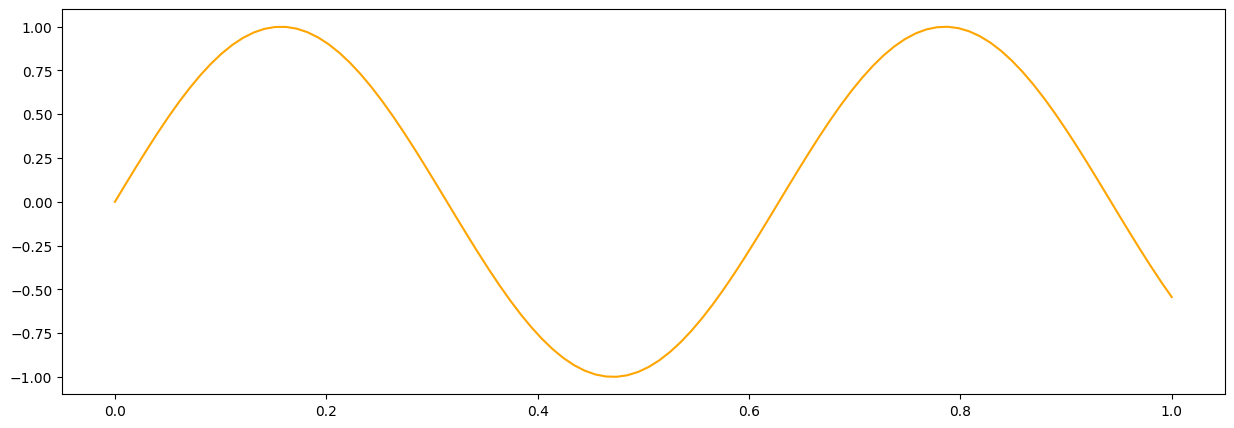

In [162]:
# It is a good idea to plot the prior mean function to make sure we did not mess up
plt.figure(figsize = (15,5))
plt.plot(x_pred1D, my_mean(x_pred1D, hps), color = 'orange', label = 'task1')

In [163]:
my_gp1 = GP(x_data, y_data,
            init_hyperparameters=hps,
            noise_variances=None, #provding noise variances and a noise function will raise a warning 
            compute_device='cpu', 
            # gp_kernel_function=rbf_kernel, 
            gp_kernel_function_grad=None, 
            # gp_mean_function=my_mean, 
            gp_mean_function_grad=None,
            gp_noise_function=my_noise,
            gp2Scale = False, 
            calc_inv=False, 
            ram_economy=False, 
            args=None,
            )

hps_bounds = np.array([[1e-5,1000],    # length scale for the kernel          # default kernel function has this as signal variance and vice versa
                       [0.01,5.],      # signal variance for the kernel
                       [0.001,100],    # noise
                       [0.01,60]       # mean
                      ])

my_gp1.train(hyperparameter_bounds=hps_bounds, # max_iter=100,
             init_hyperparameters=hps)

print("Global Training")
print(my_gp1.get_hyperparameters())

print("Log Likelihood: ", my_gp1.log_likelihood())

Global Training
[ 8.10202918  0.11927795  0.17445712 42.18194648]
Log Likelihood:  -32.36720862334313


3.312055026452704
(3.1904309535707114, 3.784328553293504)


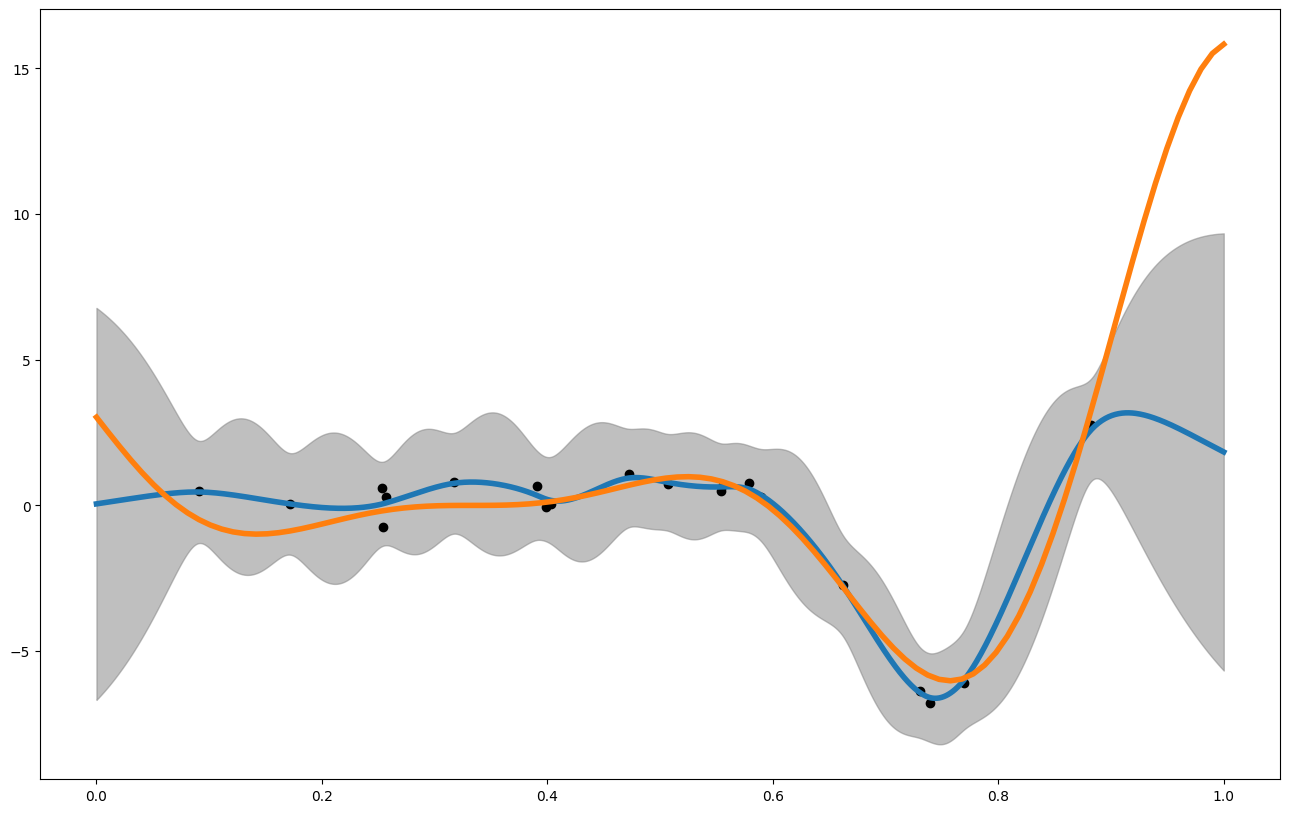

In [164]:
#let's make a prediction
x_pred = np.linspace(0,1,1000)

mean1 = my_gp1.posterior_mean(x_pred.reshape(-1,1))["f(x)"]
var1 =  my_gp1.posterior_covariance(x_pred.reshape(-1,1), variance_only=False, add_noise=True)["v(x)"]

plt.figure(figsize = (16,10))
plt.plot(x_pred,mean1, label = "posterior mean", linewidth = 4)
plt.plot(x_pred1D,forreal(x_pred1D), label = "latent function", linewidth = 4)
plt.fill_between(x_pred, mean1 - 3. * np.sqrt(var1), mean1 + 3. * np.sqrt(var1), alpha = 0.5, color = "grey", label = "var")
plt.scatter(x_data,y_data, color = 'black')


##looking at some validation metrics
print(my_gp1.rmse(x_pred1D, forreal(x_pred1D)))
print(my_gp1.crps(x_pred1D, forreal(x_pred1D)))

In [ ]:
# gp_kernel_function (Callable, optional) – A symmetric positive definite covariance function
#  (a kernel) that calculates the covariance between data points. It is a function of the form 
# k(x1,x2,hyperparameters). The input x1 is a N1 x D array of positions, x2 is a N2 x D array of
#  positions, the hyperparameters argument is a 1d array of length D+1 for the default kernel 
# and of a different length for user-defined kernels. The default is a stationary anisotropic
#  kernel (fvgp.GP.default_kernel) which performs automatic relevance determination (ARD). 
# The output is a matrix, an N1 x N2 numpy array.

# gp_mean_function (Callable, optional) – A function that evaluates the prior mean at a set
#  of input position. It accepts as input an array of positions (of shape N1 x D) and hyperparameters 
# (a 1d array of length D+1 for the default kernel). The return value is a 1d array of length N1. 
# If None is provided, fvgp.GP._default_mean_function is used, which is the average of the y_data.

# gp_noise_function (Callable, optional) – The noise function is a callable f(x,hyperparameters) 
# that returns a vector (1d np.ndarray) of length(x). The input x is a numpy array of shape (N x D).
#  The hyperparameter array is the same that is communicated to mean and kernel functions.
#  Only provide a noise function OR a noise variance vector, not both.
